In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  STI6WR1Z_11_56_05
NN-MODEL FILENAME:  ./models/STI6WR1Z_11_56_05_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 20
NO_OF_EPISODES = 200
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  20
Number of EPISODES per NODE 200


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000

In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  4.5
P_VEL_ABS_MIN = -4.5

LENGTH_ABS_MAX = 0.8
LENGTH_ABS_MIN = 0.2

In [14]:
# SET GRANULARITY
LO_GRAIN = 15
HI_GRAIN = 30
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  30
LO_GRAIN =  15


In [15]:
def mp_node_run(node_id, boundary):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.5 + (1.5 - 0.5) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = boundary
    ###############################################
        
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_ABS_MIN, LENGTH_ABS_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################

    
#     my_dqn = D3QN()
#     my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
#     my_dqn.eval_net.eval()
    my_QFILE   = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
    my_Q_TABLE = np.load(my_QFILE)
#     my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , LO_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    my_EPSILON   = T_EPSILON
    my_LR        = T_LR

    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.05,0.05)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - 
#                                                                          my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

#     LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX + 0.1, LENGTH_ABS_MAX)
#     LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN - 0.1, LENGTH_ABS_MAX)
    ###############################################

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
dqn = D3QN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# INITIALIZE QFILES FOR EACH NODE
#############################################################################################################################################
# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]

 # SET STATE VALUE BORDERS
###############################################
[C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
 C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = init_node_boundary
###############################################

# CREATE STATE COMBINATIONS
###############################################

init_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
###############################################

# GET Q-VALUES 
start = timeit.default_timer()
% memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# for node_id in range(NO_OF_NODES):
node_QFILE = './Q_NPY/' + RNDM_STRING +  'QFILE' + ".npy"
np.save(node_QFILE, init_q_table)
#############################################################################################################################################

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES

peak memory: 5612.90 MiB, increment: 5007.18 MiB
Quantization TIME:  0.05 minutes




ITERATION # 0
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 0: 86
REAL TIME TO GENERATE 40713 EXPERIENCES:0:00:01.044175


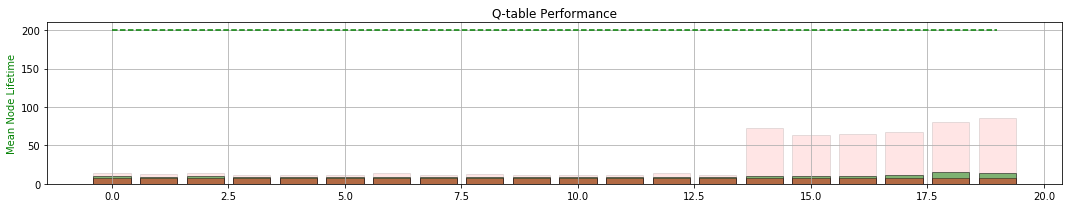

GOOD MEMORY COUNTER:  36713
BAD MEMORY COUNTER:  4000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.235
Validating... MEAN TIME:  21.49
Validating... MEAN TIME:  54.875
Validating... MEAN TIME:  44.955
Validating... MEAN TIME:  46.1
TRAINING TIME:0:00:16.481334


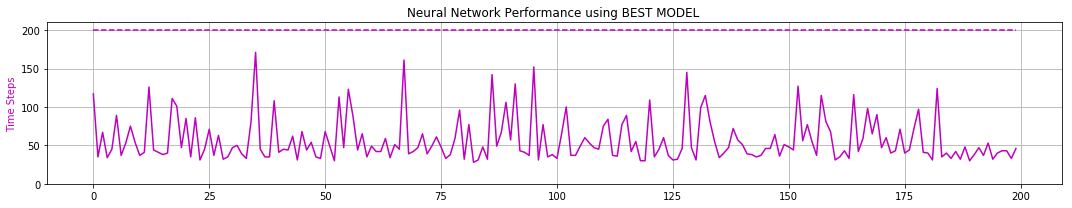

0 -max- [ 0.213  1.992  0.050  0.345  0.325]
0 -min- [-0.049 -0.237 -0.209 -2.974  0.225]

1 -max- [ 0.208  1.996  0.050  0.317  0.350]
1 -min- [-0.050 -0.232 -0.209 -2.949  0.250]

2 -max- [ 0.227  1.952  0.050  0.325  0.374]
2 -min- [-0.050 -0.221 -0.209 -2.937  0.275]

3 -max- [ 0.228  1.990  0.050  0.050  0.399]
3 -min- [-0.050 -0.050 -0.209 -2.983  0.300]

4 -max- [ 0.210  1.980  0.049  0.309  0.425]
4 -min- [-0.050 -0.175 -0.209 -2.966  0.326]

5 -max- [ 0.193  1.988  0.049  0.311  0.450]
5 -min- [-0.049 -0.151 -0.209 -2.951  0.350]

6 -max- [ 0.217  1.997  0.050  0.318  0.474]
6 -min- [-0.050 -0.238 -0.209 -2.973  0.375]

7 -max- [ 0.195  1.944  0.050  0.320  0.499]
7 -min- [-0.050 -0.151 -0.209 -2.912  0.401]

8 -max- [ 0.214  1.998  0.049  0.255  0.525]
8 -min- [-0.050 -0.150 -0.209 -2.973  0.426]

9 -max- [ 0.213  1.965  0.049  0.251  0.550]
9 -min- [-0.050 -0.170 -0.209 -2.979  0.451]

10 -max- [ 0.205  1.969  0.050  0.281  0.574]
10 -min- [-0.049 -0.226 -0.209 -2.968  0.475

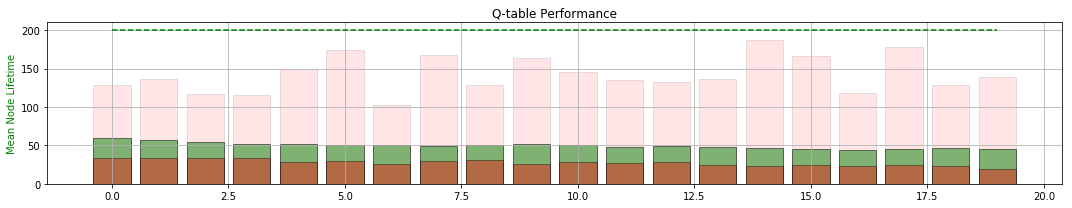

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  8000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  116.0
Validating... MEAN TIME:  199.985
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:46.266106


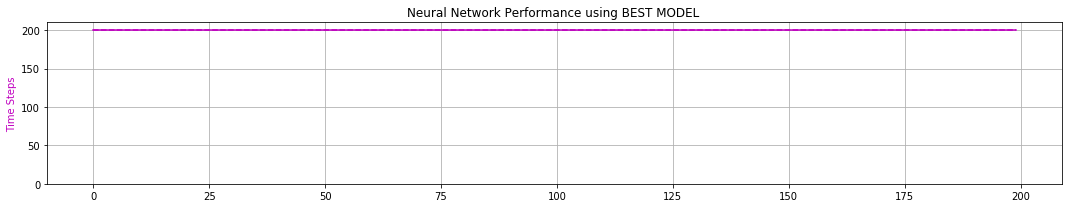

0 -max- [ 0.929  3.209  0.209  1.350  0.325]
0 -min- [-0.399 -0.768 -0.208 -2.805  0.225]

1 -max- [ 0.978  2.617  0.209  1.336  0.350]
1 -min- [-0.442 -0.770 -0.207 -1.972  0.250]

2 -max- [ 0.944  2.009  0.209  1.040  0.375]
2 -min- [-0.418 -0.725 -0.208 -1.077  0.276]

3 -max- [ 0.256  1.067  0.209  1.127  0.400]
3 -min- [-0.422 -0.754 -0.208 -0.869  0.300]

4 -max- [ 0.199  1.048  0.209  0.960  0.424]
4 -min- [-0.552 -0.744 -0.205 -0.891  0.325]

5 -max- [ 0.176  0.881  0.209  0.970  0.450]
5 -min- [-0.665 -0.733 -0.203 -0.786  0.352]

6 -max- [ 0.151  0.892  0.209  1.075  0.474]
6 -min- [-0.433 -0.735 -0.205 -0.790  0.375]

7 -max- [ 0.153  0.776  0.209  1.058  0.499]
7 -min- [-0.455 -0.726 -0.206 -0.797  0.402]

8 -max- [ 0.131  0.709  0.209  0.958  0.525]
8 -min- [-0.565 -0.772 -0.208 -0.795  0.425]

9 -max- [ 0.141  0.757  0.209  1.001  0.549]
9 -min- [-0.532 -0.763 -0.209 -0.813  0.450]

10 -max- [ 0.125  0.771  0.209  0.940  0.575]
10 -min- [-0.531 -0.765 -0.208 -0.806  0.475

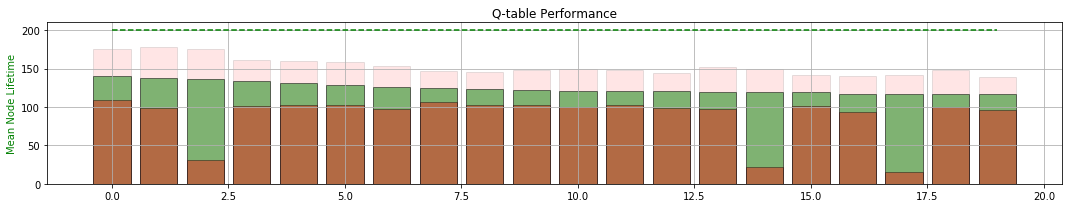

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  12000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  126.86
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  176.18
TRAINING TIME:0:00:46.116429


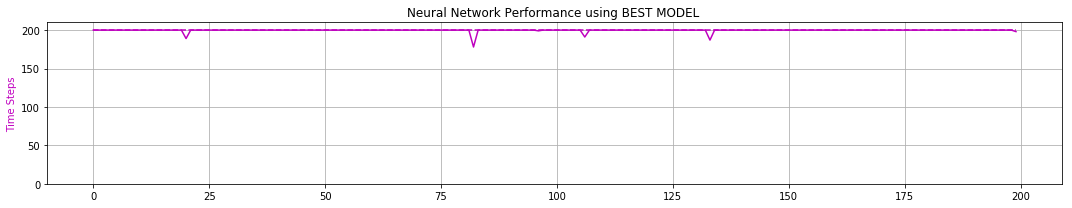

0 -max- [ 0.166  1.965  0.209  1.071  0.324]
0 -min- [-2.400 -2.012 -0.209 -3.512  0.227]

1 -max- [ 0.172  1.991  0.209  1.119  0.349]
1 -min- [-2.400 -2.206 -0.208 -3.515  0.251]

2 -max- [ 0.182  1.979  0.209  1.016  0.374]
2 -min- [-2.400 -2.040 -0.209 -3.519  0.275]

3 -max- [ 0.190  1.992  0.209  1.079  0.399]
3 -min- [-2.400 -2.223 -0.208 -3.477  0.301]

4 -max- [ 0.175  1.829  0.209  1.146  0.425]
4 -min- [-2.400 -2.259 -0.209 -3.480  0.325]

5 -max- [ 0.156  1.652  0.209  1.309  0.450]
5 -min- [-2.400 -2.444 -0.208 -3.369  0.351]

6 -max- [ 0.171  1.460  0.209  1.268  0.475]
6 -min- [-2.400 -2.457 -0.200 -3.255  0.375]

7 -max- [ 0.157  1.253  0.208  1.387  0.499]
7 -min- [-2.400 -2.656 -0.204 -3.196  0.400]

8 -max- [ 0.175  0.894  0.208  1.414  0.524]
8 -min- [-2.400 -2.645 -0.184 -2.827  0.426]

9 -max- [ 0.163  1.248  0.195  1.361  0.550]
9 -min- [-2.400 -2.819 -0.197 -3.183  0.450]

10 -max- [ 0.166  0.624  0.195  1.353  0.574]
10 -min- [-2.400 -2.650 -0.184 -1.001  0.475

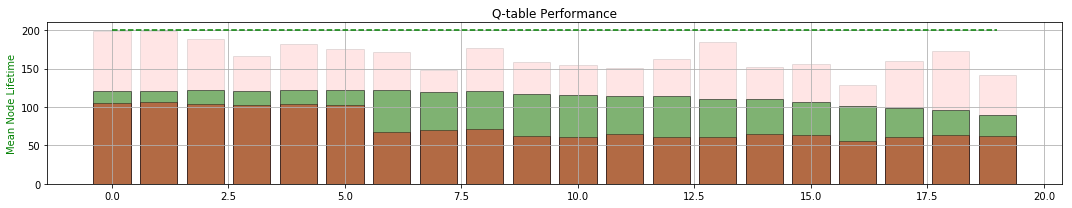

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  16000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  116.32
Validating... MEAN TIME:  144.01
Validating... MEAN TIME:  95.925
Validating... MEAN TIME:  111.045
Validating... MEAN TIME:  97.145
TRAINING TIME:0:00:32.486368


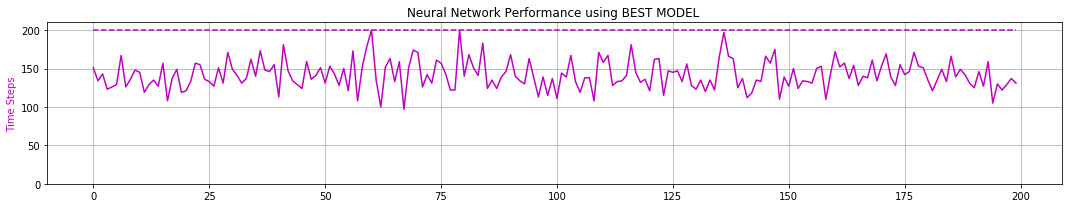

0 -max- [ 0.144  0.588  0.050  0.677  0.325]
0 -min- [-2.400 -2.782 -0.199 -0.914  0.225]

1 -max- [ 0.152  0.627  0.050  0.859  0.349]
1 -min- [-2.398 -2.794 -0.193 -0.887  0.250]

2 -max- [ 0.171  0.619  0.050  0.837  0.374]
2 -min- [-2.399 -2.795 -0.193 -0.883  0.275]

3 -max- [ 0.197  0.553  0.050  0.679  0.400]
3 -min- [-2.400 -2.908 -0.194 -0.812  0.301]

4 -max- [ 0.232  0.578  0.049  0.656  0.425]
4 -min- [-2.400 -2.981 -0.191 -0.868  0.325]

5 -max- [ 0.199  0.615  0.051  0.873  0.447]
5 -min- [-2.400 -3.080 -0.202 -0.983  0.350]

6 -max- [ 0.200  0.576  0.050  0.780  0.475]
6 -min- [-2.400 -2.982 -0.209 -1.051  0.375]

7 -max- [ 0.140  0.770  0.050  0.651  0.500]
7 -min- [-2.400 -2.978 -0.208 -1.088  0.400]

8 -max- [ 0.186  0.752  0.060  0.820  0.523]
8 -min- [-2.400 -3.163 -0.209 -1.001  0.425]

9 -max- [ 0.146  0.752  0.049  0.639  0.550]
9 -min- [-2.400 -3.136 -0.208 -1.032  0.450]

10 -max- [ 0.143  0.753  0.050  0.846  0.575]
10 -min- [-2.400 -3.124 -0.208 -1.042  0.475

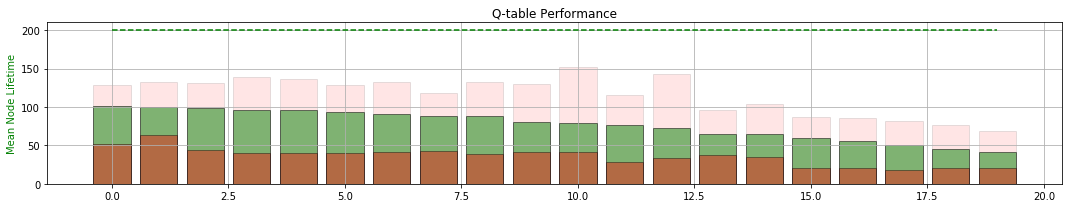

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  20000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  192.985
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  134.625
Validating... MEAN TIME:  157.29
TRAINING TIME:0:00:46.212031


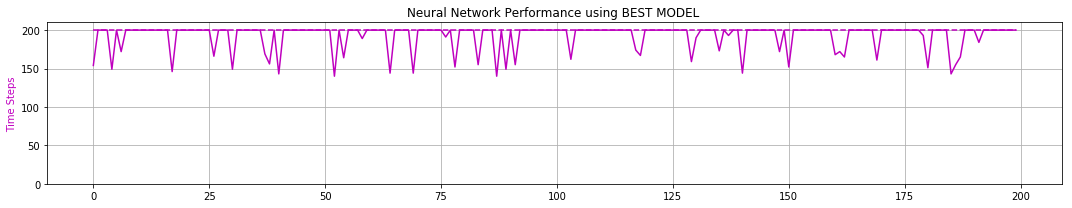

0 -max- [ 0.148  0.632  0.058  0.766  0.323]
0 -min- [-2.161 -2.711 -0.209 -0.839  0.226]

1 -max- [ 0.152  0.574  0.050  0.731  0.350]
1 -min- [-2.314 -2.921 -0.209 -0.932  0.250]

2 -max- [ 0.157  0.630  0.054  0.653  0.375]
2 -min- [-2.281 -2.874 -0.209 -0.912  0.275]

3 -max- [ 0.206  0.573  0.050  0.621  0.399]
3 -min- [-2.158 -2.783 -0.209 -0.834  0.300]

4 -max- [ 0.149  0.593  0.049  0.613  0.424]
4 -min- [-2.166 -2.736 -0.209 -1.113  0.325]

5 -max- [ 0.136  0.628  0.049  0.611  0.449]
5 -min- [-2.079 -2.588 -0.209 -0.869  0.351]

6 -max- [ 0.148  0.736  0.050  0.605  0.474]
6 -min- [-2.057 -2.697 -0.209 -1.010  0.375]

7 -max- [ 0.130  0.770  0.050  0.562  0.500]
7 -min- [-2.049 -2.719 -0.209 -1.040  0.400]

8 -max- [ 0.154  0.767  0.055  0.622  0.525]
8 -min- [-1.989 -2.686 -0.209 -1.030  0.426]

9 -max- [ 0.163  0.752  0.049  0.632  0.550]
9 -min- [-1.865 -2.601 -0.209 -1.032  0.451]

10 -max- [ 0.158  0.752  0.050  0.608  0.575]
10 -min- [-2.010 -2.773 -0.209 -1.028  0.475

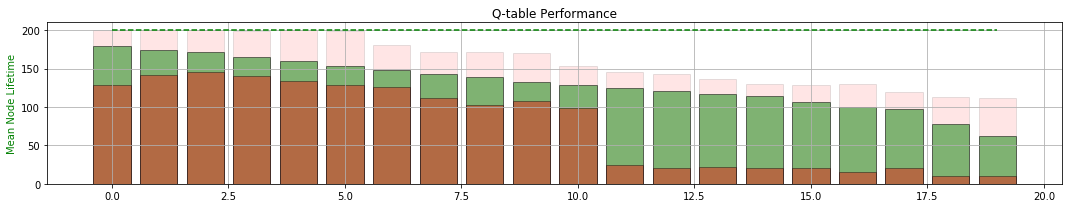

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  23944
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.45
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.685
Validating... MEAN TIME:  199.99
TRAINING TIME:0:00:49.401989


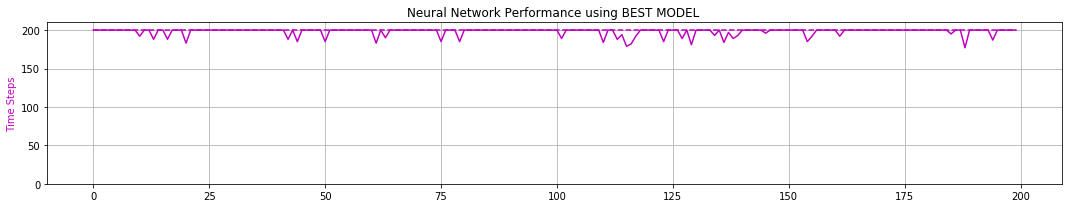

0 -max- [ 0.158  0.629  0.109  1.139  0.325]
0 -min- [-2.400 -2.410 -0.209 -2.272  0.228]

1 -max- [ 0.154  0.614  0.102  0.999  0.349]
1 -min- [-2.399 -2.451 -0.209 -2.086  0.250]

2 -max- [ 0.164  0.627  0.099  0.956  0.374]
2 -min- [-2.400 -2.447 -0.209 -2.085  0.275]

3 -max- [ 0.172  0.625  0.085  0.989  0.397]
3 -min- [-2.400 -2.571 -0.209 -1.711  0.300]

4 -max- [ 0.152  0.791  0.101  1.004  0.424]
4 -min- [-2.400 -2.435 -0.209 -2.100  0.325]

5 -max- [ 0.148  0.633  0.104  0.936  0.449]
5 -min- [-2.400 -2.344 -0.209 -2.082  0.350]

6 -max- [ 0.159  0.634  0.088  0.931  0.475]
6 -min- [-2.399 -2.393 -0.209 -1.644  0.375]

7 -max- [ 0.153  0.637  0.082  0.817  0.499]
7 -min- [-2.400 -2.380 -0.209 -1.733  0.400]

8 -max- [ 0.168  0.636  0.072  0.982  0.524]
8 -min- [-2.400 -2.536 -0.209 -1.712  0.426]

9 -max- [ 0.169  0.636  0.071  1.007  0.550]
9 -min- [-2.399 -2.407 -0.209 -1.734  0.450]

10 -max- [ 0.174  0.629  0.071  0.981  0.575]
10 -min- [-2.400 -2.534 -0.209 -1.687  0.475

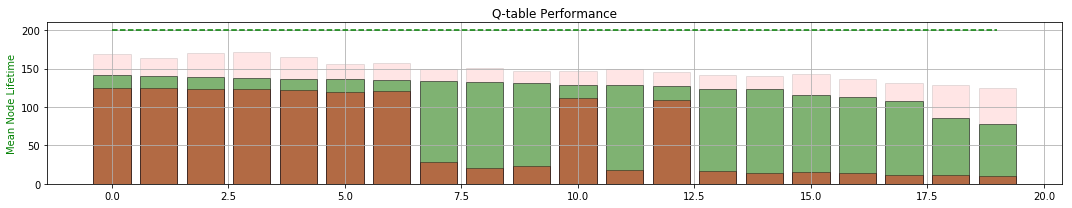

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  27944
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  112.625
Validating... MEAN TIME:  122.715
Validating... MEAN TIME:  104.92
Validating... MEAN TIME:  108.35
Validating... MEAN TIME:  150.125
TRAINING TIME:0:00:33.764897


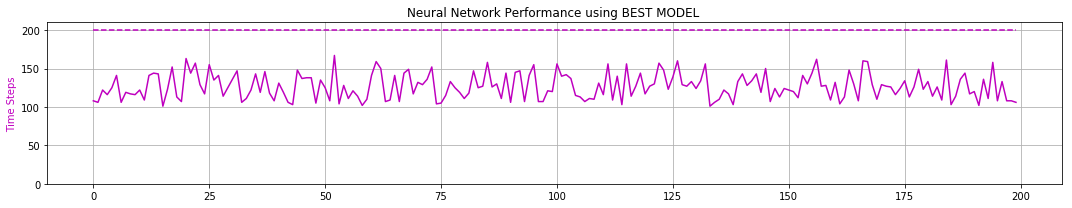

0 -max- [ 0.163  0.638  0.073  0.994  0.325]
0 -min- [-2.400 -2.450 -0.206 -1.109  0.225]

1 -max- [ 0.167  0.631  0.066  0.982  0.349]
1 -min- [-2.400 -2.244 -0.207 -1.092  0.251]

2 -max- [ 0.174  0.637  0.066  0.915  0.375]
2 -min- [-2.400 -2.450 -0.209 -1.080  0.275]

3 -max- [ 0.187  0.641  0.063  0.991  0.400]
3 -min- [-2.400 -2.448 -0.209 -1.116  0.300]

4 -max- [ 0.160  0.631  0.087  0.940  0.424]
4 -min- [-2.400 -2.238 -0.209 -1.093  0.325]

5 -max- [ 0.151  0.637  0.078  0.953  0.449]
5 -min- [-2.400 -2.449 -0.209 -1.062  0.350]

6 -max- [ 0.170  0.793  0.109  1.216  0.475]
6 -min- [-2.400 -2.359 -0.209 -1.153  0.375]

7 -max- [ 0.153  0.808  0.082  0.750  0.499]
7 -min- [-2.400 -2.220 -0.209 -1.150  0.401]

8 -max- [ 0.170  0.806  0.067  0.942  0.524]
8 -min- [-2.400 -2.180 -0.209 -1.152  0.425]

9 -max- [ 0.166  0.632  0.063  0.855  0.550]
9 -min- [-2.400 -2.029 -0.208 -1.101  0.450]

10 -max- [ 0.177  0.819  0.066  0.915  0.574]
10 -min- [-2.400 -2.070 -0.209 -1.122  0.476

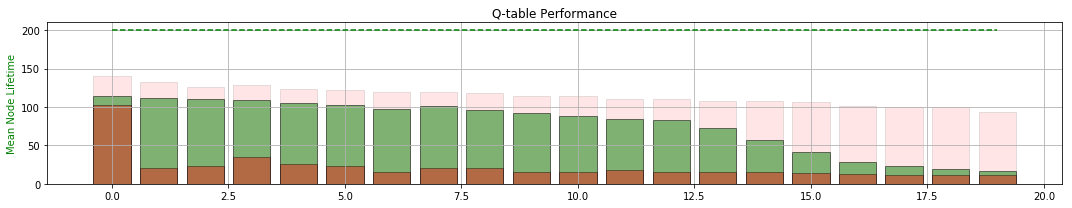

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  31944
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  12.335
Validating... MEAN TIME:  55.145
Validating... MEAN TIME:  119.19
Validating... MEAN TIME:  99.29
Validating... MEAN TIME:  107.3
TRAINING TIME:0:00:25.681462


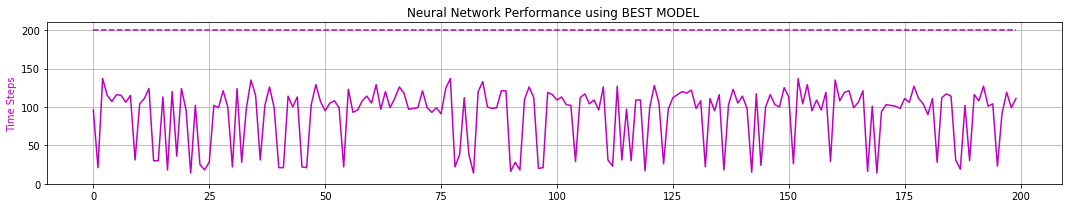

0 -max- [ 0.153  0.635  0.120  1.604  0.324]
0 -min- [-2.400 -3.189 -0.200 -0.997  0.227]

1 -max- [ 0.158  0.619  0.084  1.656  0.350]
1 -min- [-2.399 -3.207 -0.203 -1.088  0.251]

2 -max- [ 0.169  0.629  0.084  1.613  0.374]
2 -min- [-2.400 -3.209 -0.208 -1.059  0.275]

3 -max- [ 0.171  0.631  0.050  1.617  0.400]
3 -min- [-2.400 -3.210 -0.205 -1.060  0.300]

4 -max- [ 0.162  0.645  0.073  1.624  0.425]
4 -min- [-2.400 -3.197 -0.209 -1.400  0.326]

5 -max- [ 0.153  0.821  0.078  1.651  0.450]
5 -min- [-2.400 -3.207 -0.209 -1.161  0.350]

6 -max- [ 0.171  0.633  0.067  1.639  0.475]
6 -min- [-2.400 -3.195 -0.209 -0.998  0.376]

7 -max- [ 0.160  0.771  0.060  1.489  0.500]
7 -min- [-2.400 -3.187 -0.209 -1.090  0.400]

8 -max- [ 0.177  0.812  0.082  1.572  0.522]
8 -min- [-2.400 -3.202 -0.209 -1.192  0.425]

9 -max- [ 0.170  0.728  0.122  1.542  0.550]
9 -min- [-2.400 -3.208 -0.209 -1.086  0.450]

10 -max- [ 0.183  0.821  0.082  1.493  0.575]
10 -min- [-2.399 -3.177 -0.209 -1.227  0.475

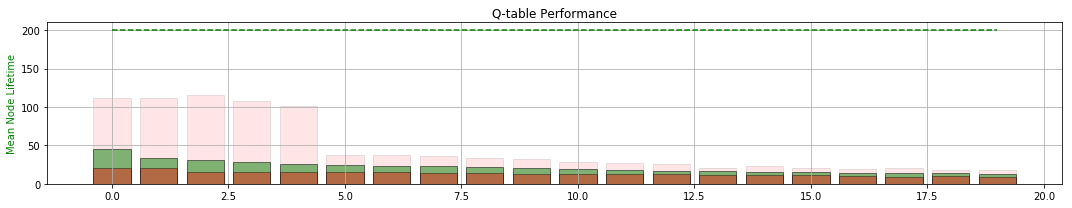

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  35944
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  31.48
Validating... MEAN TIME:  11.615
Validating... MEAN TIME:  199.66
Validating... MEAN TIME:  11.53
Validating... MEAN TIME:  13.23
TRAINING TIME:0:00:20.260374


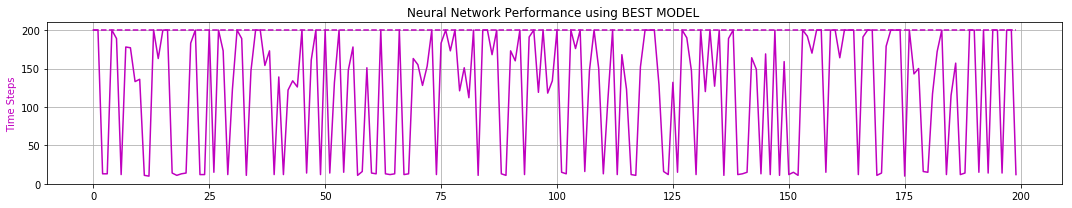

0 -max- [ 0.175  0.775  0.110  1.303  0.325]
0 -min- [-2.399 -2.830 -0.209 -1.115  0.225]

1 -max- [ 0.184  0.800  0.071  1.201  0.349]
1 -min- [-2.394 -2.814 -0.209 -1.206  0.251]

2 -max- [ 0.205  0.766  0.071  1.003  0.375]
2 -min- [-2.395 -2.957 -0.209 -1.211  0.275]

3 -max- [ 0.215  0.743  0.057  1.029  0.400]
3 -min- [-2.399 -2.933 -0.209 -1.125  0.301]

4 -max- [ 0.184  0.801  0.072  1.269  0.424]
4 -min- [-2.368 -3.129 -0.209 -1.217  0.326]

5 -max- [ 0.176  0.821  0.049  0.356  0.450]
5 -min- [-0.049 -0.918 -0.209 -1.199  0.350]

6 -max- [ 0.190  1.019  0.050  0.360  0.474]
6 -min- [-0.050 -0.949 -0.209 -1.538  0.376]

7 -max- [ 0.181  0.830  0.050  0.365  0.500]
7 -min- [-0.054 -0.926 -0.209 -1.229  0.400]

8 -max- [ 0.196  0.951  0.056  0.349  0.525]
8 -min- [-0.050 -0.765 -0.209 -1.370  0.425]

9 -max- [ 0.190  0.979  0.049  0.323  0.549]
9 -min- [-0.050 -0.782 -0.209 -1.391  0.450]

10 -max- [ 0.199  1.014  0.052  0.322  0.574]
10 -min- [-0.049 -0.590 -0.209 -1.454  0.475

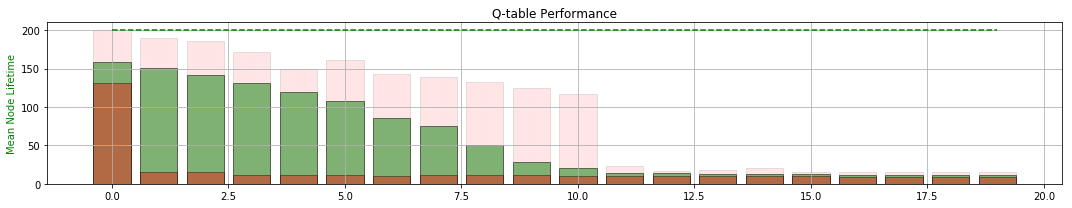

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  39938
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  41.455
Validating... MEAN TIME:  108.35
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  122.845
Validating... MEAN TIME:  75.62
TRAINING TIME:0:00:31.723197


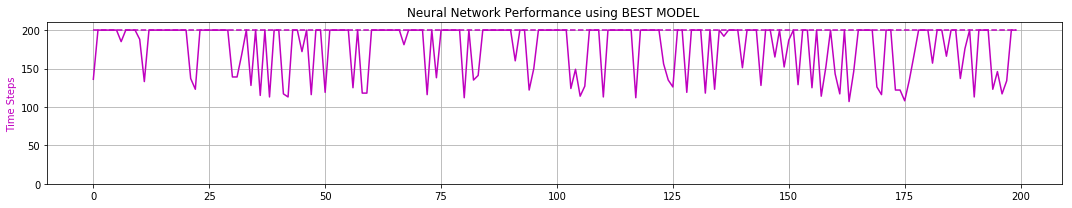

0 -max- [ 0.178  0.814  0.132  1.183  0.325]
0 -min- [-2.400 -2.438 -0.194 -1.161  0.226]

1 -max- [ 0.186  0.786  0.100  0.991  0.350]
1 -min- [-2.400 -2.215 -0.205 -1.263  0.250]

2 -max- [ 0.189  0.825  0.079  0.910  0.375]
2 -min- [-2.400 -2.259 -0.209 -1.344  0.275]

3 -max- [ 0.213  0.945  0.086  1.030  0.400]
3 -min- [-2.400 -2.411 -0.208 -1.362  0.300]

4 -max- [ 0.191  1.001  0.061  0.969  0.424]
4 -min- [-2.400 -2.262 -0.209 -1.392  0.325]

5 -max- [ 0.185  1.013  0.055  0.880  0.450]
5 -min- [-2.399 -2.344 -0.209 -1.390  0.350]

6 -max- [ 0.213  1.015  0.062  0.935  0.474]
6 -min- [-2.400 -2.447 -0.209 -1.740  0.375]

7 -max- [ 0.200  0.967  0.050  0.881  0.500]
7 -min- [-2.400 -2.345 -0.209 -1.412  0.400]

8 -max- [ 0.207  1.022  0.049  0.854  0.525]
8 -min- [-2.399 -2.261 -0.209 -1.564  0.426]

9 -max- [ 0.207  1.023  0.049  0.869  0.550]
9 -min- [-2.398 -2.444 -0.209 -1.486  0.450]

10 -max- [ 0.218  1.014  0.073  0.707  0.575]
10 -min- [-2.396 -2.436 -0.209 -1.553  0.475

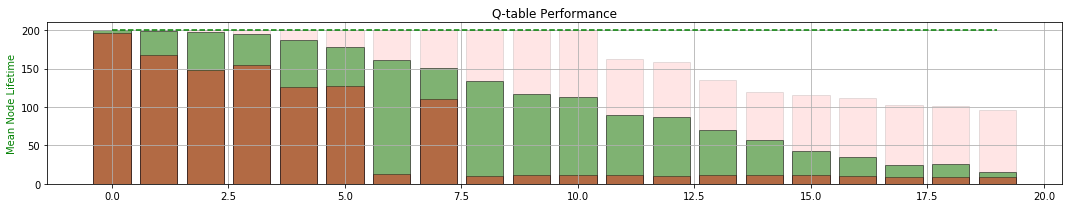

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  42965
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  81.915
Validating... MEAN TIME:  186.63
Validating... MEAN TIME:  50.885
Validating... MEAN TIME:  11.14
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:31.278245


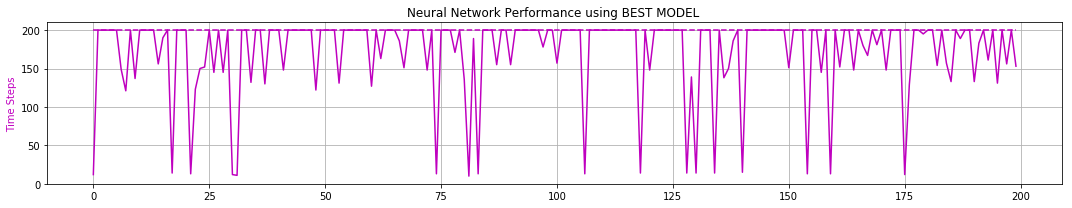

0 -max- [ 0.288  1.012  0.126  0.962  0.324]
0 -min- [-2.398 -2.254 -0.157 -1.334  0.226]

1 -max- [ 0.227  1.135  0.111  0.993  0.350]
1 -min- [-2.399 -2.442 -0.186 -1.336  0.251]

2 -max- [ 0.188  1.130  0.092  1.004  0.375]
2 -min- [-2.399 -2.443 -0.196 -1.554  0.275]

3 -max- [ 0.176  1.010  0.104  0.981  0.399]
3 -min- [-2.399 -2.445 -0.187 -1.368  0.301]

4 -max- [ 0.189  1.171  0.093  0.962  0.425]
4 -min- [-2.400 -2.538 -0.183 -1.409  0.326]

5 -max- [ 0.172  1.013  0.073  0.985  0.449]
5 -min- [-2.400 -2.446 -0.198 -1.408  0.350]

6 -max- [ 0.190  0.971  0.064  0.997  0.475]
6 -min- [-2.400 -2.444 -0.204 -1.368  0.376]

7 -max- [ 0.182  0.923  0.066  0.999  0.500]
7 -min- [-2.400 -2.633 -0.205 -1.316  0.400]

8 -max- [ 0.192  1.019  0.061  0.916  0.525]
8 -min- [-2.400 -2.598 -0.209 -1.575  0.426]

9 -max- [ 0.204  0.983  0.054  0.941  0.550]
9 -min- [-2.400 -2.635 -0.209 -1.391  0.450]

10 -max- [ 0.217  1.014  0.055  0.919  0.575]
10 -min- [-2.400 -2.607 -0.209 -1.449  0.475

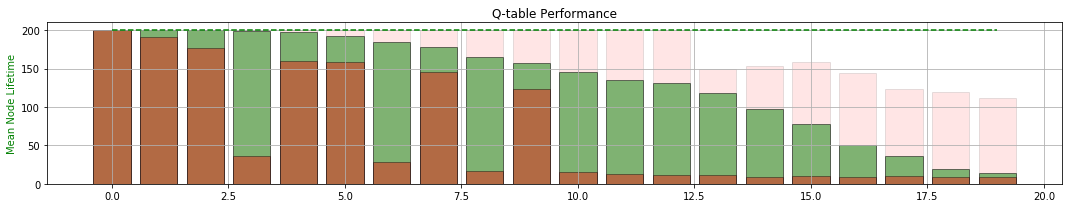

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  45654
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  19.435
Validating... MEAN TIME:  84.26
Validating... MEAN TIME:  141.395
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  194.765
TRAINING TIME:0:00:34.837374


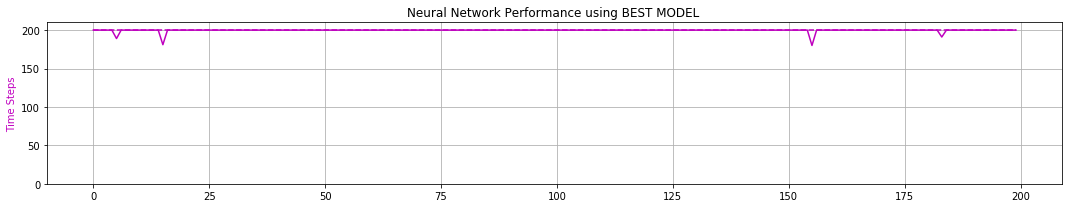

0 -max- [ 0.217  1.008  0.101  0.932  0.323]
0 -min- [-1.688 -1.684 -0.168 -1.347  0.226]

1 -max- [ 0.204  0.981  0.100  0.984  0.349]
1 -min- [-2.378 -2.069 -0.174 -1.304  0.250]

2 -max- [ 0.208  1.017  0.076  0.965  0.375]
2 -min- [-2.389 -2.066 -0.155 -1.348  0.276]

3 -max- [ 0.199  0.936  0.083  0.900  0.399]
3 -min- [-2.383 -2.438 -0.201 -1.397  0.301]

4 -max- [ 0.198  1.012  0.086  0.950  0.425]
4 -min- [-2.400 -2.249 -0.190 -1.610  0.326]

5 -max- [ 0.176  0.822  0.077  0.881  0.449]
5 -min- [-2.400 -2.380 -0.183 -1.134  0.350]

6 -max- [ 0.198  0.965  0.076  0.878  0.474]
6 -min- [-2.400 -2.437 -0.208 -1.427  0.375]

7 -max- [ 0.177  0.985  0.087  0.948  0.500]
7 -min- [-2.400 -2.527 -0.175 -1.455  0.401]

8 -max- [ 0.182  1.019  0.063  0.952  0.524]
8 -min- [-2.399 -2.400 -0.204 -1.370  0.426]

9 -max- [ 0.194  1.001  0.061  0.997  0.550]
9 -min- [-2.400 -2.564 -0.207 -1.496  0.451]

10 -max- [ 0.203  1.141  0.057  0.941  0.574]
10 -min- [-2.400 -2.389 -0.209 -1.688  0.476

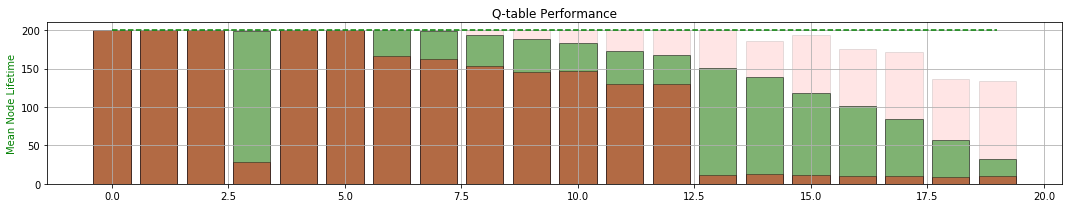

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  47694
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  181.585
Validating... MEAN TIME:  133.985
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:45.376991


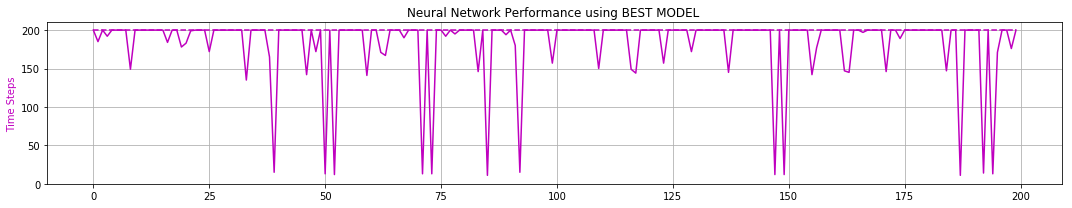

0 -max- [ 0.229  1.023  0.116  0.966  0.323]
0 -min- [-1.293 -1.273 -0.140 -1.490  0.226]

1 -max- [ 0.243  1.009  0.098  0.984  0.349]
1 -min- [-2.267 -1.829 -0.196 -1.371  0.250]

2 -max- [ 0.223  1.007  0.094  0.967  0.375]
2 -min- [-2.147 -1.701 -0.172 -1.375  0.276]

3 -max- [ 0.232  1.011  0.092  0.942  0.399]
3 -min- [-2.397 -2.057 -0.208 -1.383  0.301]

4 -max- [ 0.229  1.013  0.114  0.974  0.425]
4 -min- [-2.051 -1.865 -0.168 -1.342  0.325]

5 -max- [ 0.225  0.982  0.095  0.913  0.449]
5 -min- [-2.171 -1.889 -0.173 -1.326  0.350]

6 -max- [ 0.190  0.925  0.096  1.009  0.474]
6 -min- [-2.396 -2.014 -0.184 -1.367  0.375]

7 -max- [ 0.177  0.958  0.090  1.197  0.499]
7 -min- [-2.399 -2.017 -0.201 -1.474  0.400]

8 -max- [ 0.186  0.993  0.100  0.995  0.525]
8 -min- [-2.400 -2.030 -0.167 -1.423  0.425]

9 -max- [ 0.194  1.010  0.092  0.976  0.549]
9 -min- [-2.399 -2.184 -0.190 -1.400  0.451]

10 -max- [ 0.187  1.014  0.076  0.896  0.575]
10 -min- [-2.400 -2.069 -0.202 -1.385  0.476

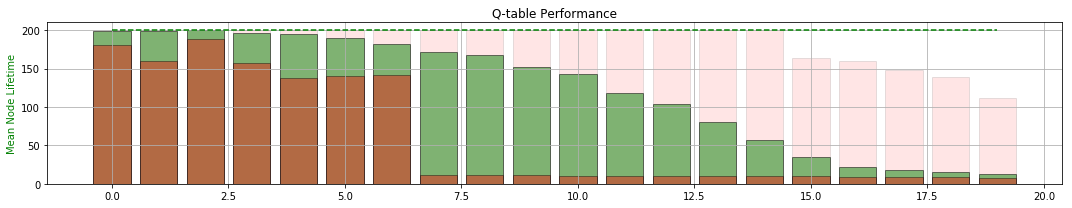

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  50615
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  181.7
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:47.526947


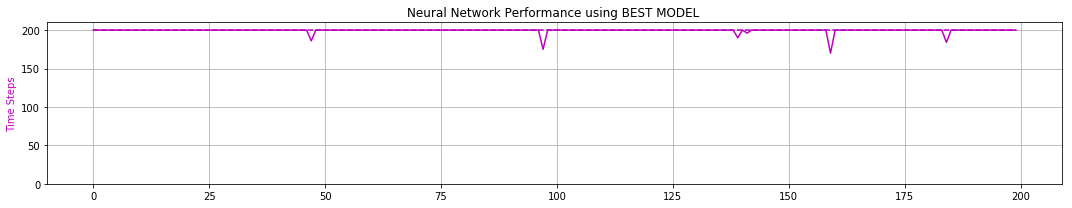

0 -max- [ 0.193  1.014  0.111  1.110  0.325]
0 -min- [-2.397 -2.067 -0.195 -1.626  0.225]

1 -max- [ 0.180  0.981  0.109  1.022  0.349]
1 -min- [-2.399 -2.046 -0.201 -1.540  0.250]

2 -max- [ 0.175  0.997  0.104  1.255  0.375]
2 -min- [-2.400 -2.041 -0.198 -1.444  0.276]

3 -max- [ 0.194  1.012  0.110  1.020  0.400]
3 -min- [-2.399 -2.207 -0.203 -1.582  0.300]

4 -max- [ 0.213  1.001  0.093  1.032  0.424]
4 -min- [-2.400 -2.351 -0.207 -1.492  0.325]

5 -max- [ 0.184  1.013  0.099  1.073  0.450]
5 -min- [-2.399 -2.383 -0.205 -1.576  0.351]

6 -max- [ 0.198  1.166  0.087  1.020  0.474]
6 -min- [-2.400 -2.421 -0.204 -1.656  0.375]

7 -max- [ 0.184  1.161  0.123  1.020  0.499]
7 -min- [-2.400 -2.547 -0.209 -1.644  0.400]

8 -max- [ 0.191  1.214  0.081  0.987  0.525]
8 -min- [-2.400 -2.581 -0.206 -1.699  0.425]

9 -max- [ 0.194  1.189  0.092  1.096  0.550]
9 -min- [-2.400 -2.604 -0.209 -1.693  0.450]

10 -max- [ 0.220  1.211  0.078  1.022  0.575]
10 -min- [-2.400 -2.534 -0.209 -1.716  0.476

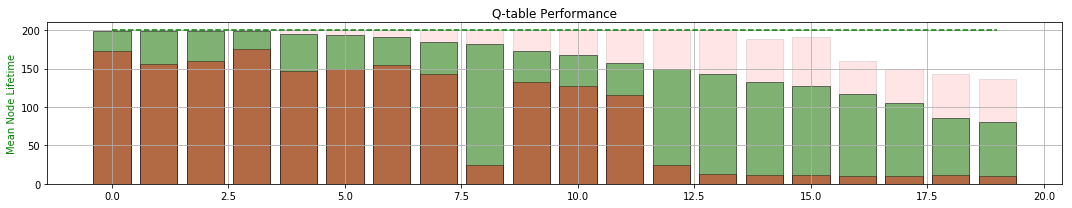

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  53421
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.63
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:50.290601


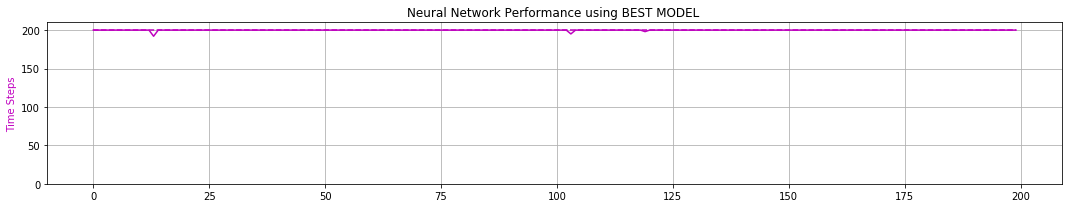

0 -max- [ 0.172  0.939  0.093  1.003  0.324]
0 -min- [-2.388 -2.581 -0.207 -1.346  0.227]

1 -max- [ 0.175  0.975  0.108  1.256  0.350]
1 -min- [-2.397 -2.599 -0.209 -1.408  0.251]

2 -max- [ 0.160  0.939  0.099  0.976  0.375]
2 -min- [-2.400 -2.576 -0.209 -1.330  0.276]

3 -max- [ 0.193  0.945  0.108  0.982  0.400]
3 -min- [-2.400 -2.586 -0.209 -1.448  0.300]

4 -max- [ 0.198  0.812  0.107  1.228  0.423]
4 -min- [-2.400 -2.599 -0.209 -1.355  0.325]

5 -max- [ 0.172  1.013  0.098  0.959  0.449]
5 -min- [-2.400 -2.710 -0.209 -1.376  0.350]

6 -max- [ 0.190  0.827  0.090  0.999  0.475]
6 -min- [-2.398 -2.585 -0.209 -1.337  0.375]

7 -max- [ 0.177  1.003  0.092  0.995  0.500]
7 -min- [-2.399 -2.754 -0.209 -1.799  0.401]

8 -max- [ 0.199  1.019  0.085  1.245  0.525]
8 -min- [-2.397 -2.740 -0.209 -1.485  0.425]

9 -max- [ 0.202  0.979  0.100  1.009  0.549]
9 -min- [-2.398 -2.730 -0.209 -1.479  0.450]

10 -max- [ 0.186  1.160  0.091  0.986  0.574]
10 -min- [-2.397 -2.575 -0.209 -1.660  0.475

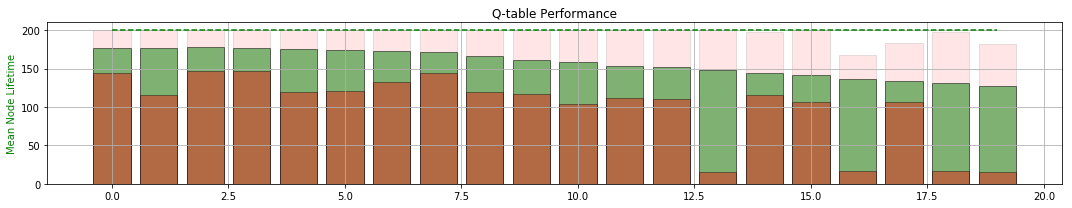

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  57322
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  188.33
Validating... MEAN TIME:  128.995
Validating... MEAN TIME:  199.98
Validating... MEAN TIME:  180.8
Validating... MEAN TIME:  168.52
TRAINING TIME:0:00:44.849130


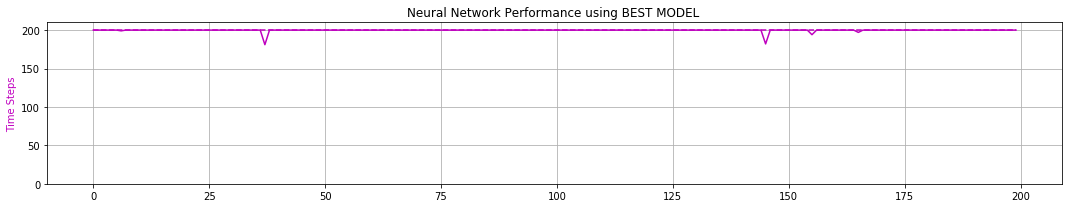

0 -max- [ 0.165  0.805  0.083  0.963  0.324]
0 -min- [-2.400 -2.446 -0.206 -1.383  0.226]

1 -max- [ 0.150  0.786  0.063  1.091  0.350]
1 -min- [-2.400 -2.546 -0.205 -1.364  0.250]

2 -max- [ 0.170  0.938  0.075  0.957  0.375]
2 -min- [-2.399 -2.444 -0.188 -1.372  0.276]

3 -max- [ 0.176  0.749  0.063  0.937  0.399]
3 -min- [-2.400 -2.446 -0.207 -1.327  0.300]

4 -max- [ 0.211  0.801  0.076  0.946  0.423]
4 -min- [-2.400 -2.546 -0.205 -1.407  0.326]

5 -max- [ 0.176  0.806  0.067  0.960  0.450]
5 -min- [-2.400 -2.603 -0.205 -1.673  0.350]

6 -max- [ 0.190  0.796  0.062  0.965  0.475]
6 -min- [-2.400 -2.450 -0.201 -1.386  0.376]

7 -max- [ 0.177  1.190  0.057  1.180  0.499]
7 -min- [-2.400 -2.629 -0.205 -1.742  0.400]

8 -max- [ 0.169  0.811  0.069  0.984  0.524]
8 -min- [-2.400 -2.559 -0.198 -1.400  0.425]

9 -max- [ 0.186  0.825  0.059  0.979  0.550]
9 -min- [-2.400 -2.752 -0.207 -1.554  0.450]

10 -max- [ 0.178  1.014  0.054  1.241  0.572]
10 -min- [-2.400 -2.559 -0.209 -1.586  0.475

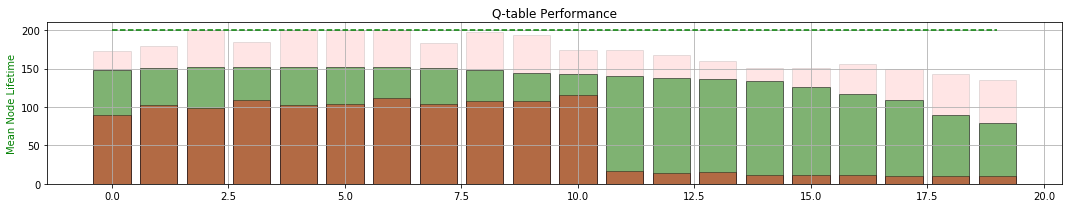

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  61316
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  159.285
Validating... MEAN TIME:  197.89
Validating... MEAN TIME:  80.195
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  184.48
TRAINING TIME:0:00:43.145765


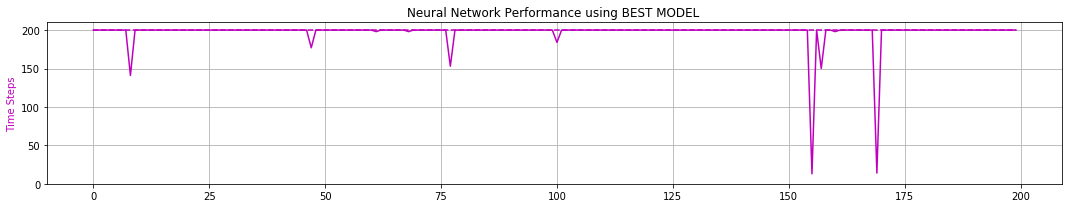

0 -max- [ 0.188  0.828  0.056  0.989  0.324]
0 -min- [-2.400 -2.367 -0.209 -1.601  0.226]

1 -max- [ 0.181  0.832  0.057  0.967  0.348]
1 -min- [-2.400 -2.218 -0.209 -1.635  0.250]

2 -max- [ 0.184  0.827  0.070  0.985  0.375]
2 -min- [-2.400 -2.212 -0.209 -1.412  0.276]

3 -max- [ 0.183  0.945  0.057  0.952  0.399]
3 -min- [-2.400 -2.253 -0.209 -1.394  0.300]

4 -max- [ 0.176  0.932  0.071  1.222  0.425]
4 -min- [-2.400 -2.452 -0.209 -1.620  0.325]

5 -max- [ 0.179  1.010  0.050  0.963  0.449]
5 -min- [-2.400 -2.247 -0.205 -1.683  0.351]

6 -max- [ 0.185  0.971  0.066  1.157  0.474]
6 -min- [-2.400 -2.260 -0.200 -1.628  0.376]

7 -max- [ 0.168  0.966  0.051  0.954  0.500]
7 -min- [-2.400 -2.225 -0.198 -1.377  0.400]

8 -max- [ 0.180  1.019  0.053  1.094  0.525]
8 -min- [-2.400 -2.214 -0.200 -1.404  0.427]

9 -max- [ 0.173  0.988  0.056  0.958  0.549]
9 -min- [-2.400 -2.253 -0.204 -1.436  0.450]

10 -max- [ 0.186  1.014  0.058  0.981  0.574]
10 -min- [-2.400 -2.238 -0.205 -1.652  0.475

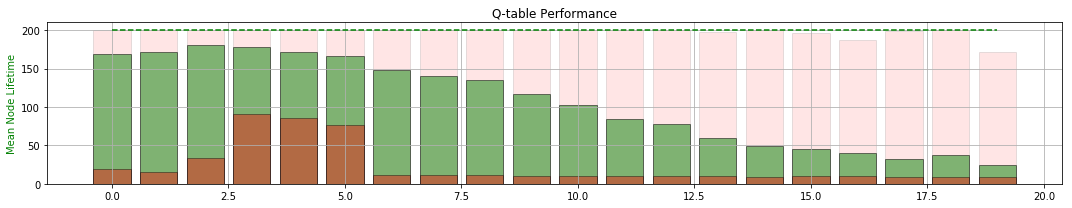

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  64877
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  160.46
Validating... MEAN TIME:  97.19
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:44.590879


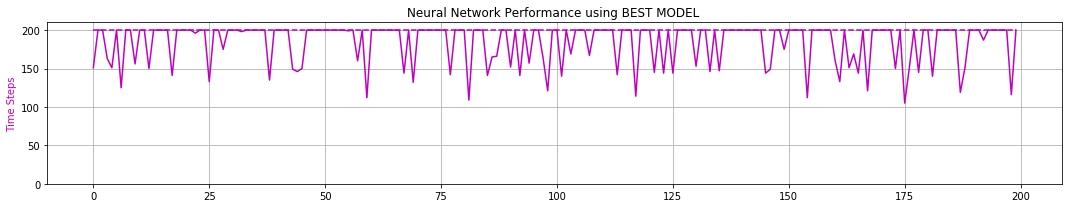

0 -max- [ 0.186  1.013  0.195  2.198  0.324]
0 -min- [-2.400 -2.348 -0.209 -1.983  0.226]

1 -max- [ 0.189  1.017  0.208  2.413  0.350]
1 -min- [-2.400 -2.419 -0.209 -1.754  0.250]

2 -max- [ 0.182  0.997  0.205  2.102  0.375]
2 -min- [-2.400 -2.261 -0.209 -1.824  0.275]

3 -max- [ 0.180  1.014  0.188  1.907  0.400]
3 -min- [-2.400 -2.384 -0.209 -1.702  0.300]

4 -max- [ 0.213  1.003  0.146  1.969  0.425]
4 -min- [-2.400 -2.489 -0.209 -1.716  0.325]

5 -max- [ 0.182  1.131  0.147  2.095  0.450]
5 -min- [-2.400 -2.424 -0.209 -1.895  0.351]

6 -max- [ 0.208  1.168  0.162  1.913  0.474]
6 -min- [-2.400 -2.428 -0.209 -1.894  0.375]

7 -max- [ 0.201  1.021  0.190  2.242  0.499]
7 -min- [-2.398 -2.410 -0.209 -1.917  0.400]

8 -max- [ 0.202  1.136  0.193  2.239  0.525]
8 -min- [-2.399 -2.431 -0.209 -1.719  0.425]

9 -max- [ 0.211  1.325  0.162  1.847  0.550]
9 -min- [-2.400 -2.444 -0.209 -1.852  0.450]

10 -max- [ 0.214  1.193  0.147  1.849  0.575]
10 -min- [-2.400 -2.437 -0.209 -1.723  0.476

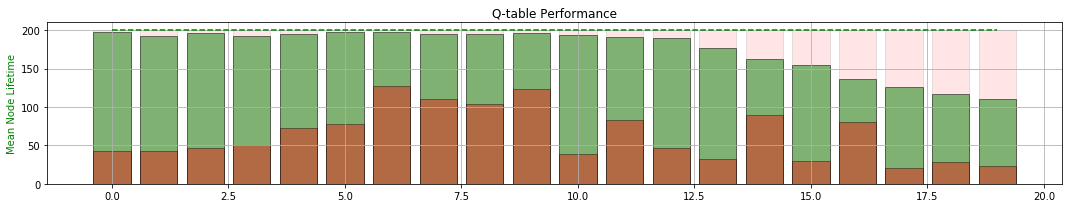

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  66464
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  134.585
Validating... MEAN TIME:  94.8
Validating... MEAN TIME:  40.185
Validating... MEAN TIME:  25.595
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:29.962332


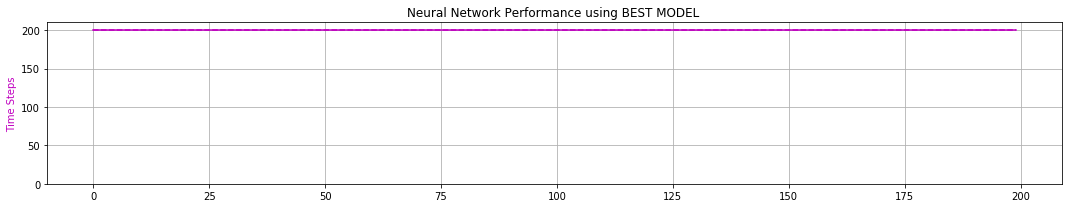

0 -max- [ 0.506  1.317  0.206  1.225  0.324]
0 -min- [-1.050 -1.464 -0.209 -1.318  0.225]

1 -max- [ 0.577  1.327  0.209  1.205  0.350]
1 -min- [-1.795 -1.345 -0.209 -1.281  0.250]

2 -max- [ 0.551  1.326  0.207  1.270  0.375]
2 -min- [-1.193 -1.553 -0.209 -1.345  0.275]

3 -max- [ 0.487  1.298  0.209  1.086  0.400]
3 -min- [-1.629 -1.458 -0.209 -1.430  0.301]

4 -max- [ 0.515  1.166  0.209  1.072  0.425]
4 -min- [-1.794 -1.462 -0.209 -1.637  0.325]

5 -max- [ 0.474  1.004  0.208  1.127  0.450]
5 -min- [-2.095 -1.473 -0.208 -1.616  0.350]

6 -max- [ 0.237  1.018  0.209  1.211  0.473]
6 -min- [-2.396 -2.067 -0.209 -1.698  0.375]

7 -max- [ 0.177  0.970  0.208  1.066  0.499]
7 -min- [-2.380 -2.059 -0.209 -1.707  0.401]

8 -max- [ 0.233  1.008  0.208  1.171  0.525]
8 -min- [-2.399 -2.056 -0.209 -1.917  0.425]

9 -max- [ 0.242  0.998  0.209  1.221  0.550]
9 -min- [-2.396 -1.998 -0.209 -1.721  0.452]

10 -max- [ 0.221  1.006  0.207  1.187  0.575]
10 -min- [-2.399 -2.069 -0.209 -1.691  0.475

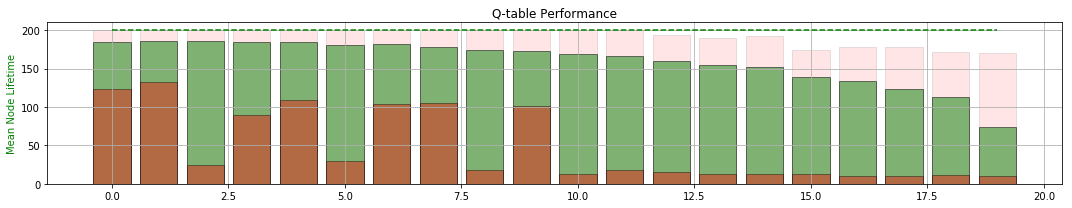

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  70188
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  198.815
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:50.422775


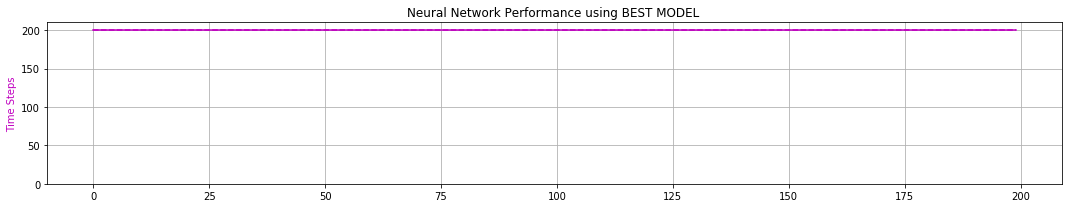

0 -max- [ 0.183  0.824  0.145  1.226  0.324]
0 -min- [-2.400 -2.244 -0.209 -2.003  0.225]

1 -max- [ 0.174  0.786  0.136  1.249  0.350]
1 -min- [-2.400 -2.202 -0.209 -1.690  0.253]

2 -max- [ 0.179  0.831  0.143  1.232  0.375]
2 -min- [-2.400 -2.212 -0.209 -1.697  0.275]

3 -max- [ 0.197  0.816  0.134  1.267  0.400]
3 -min- [-2.400 -2.262 -0.209 -1.879  0.300]

4 -max- [ 0.181  0.806  0.139  1.266  0.425]
4 -min- [-2.400 -2.224 -0.208 -1.673  0.326]

5 -max- [ 0.181  0.818  0.164  1.261  0.450]
5 -min- [-2.400 -2.178 -0.209 -1.686  0.350]

6 -max- [ 0.198  0.824  0.126  1.349  0.474]
6 -min- [-2.398 -2.164 -0.209 -1.891  0.375]

7 -max- [ 0.174  0.807  0.119  1.309  0.500]
7 -min- [-2.400 -2.235 -0.209 -1.721  0.400]

8 -max- [ 0.182  0.824  0.141  1.239  0.523]
8 -min- [-2.400 -2.227 -0.209 -1.964  0.425]

9 -max- [ 0.181  0.825  0.137  1.112  0.550]
9 -min- [-2.400 -2.386 -0.209 -1.809  0.450]

10 -max- [ 0.195  1.014  0.120  1.211  0.574]
10 -min- [-2.399 -2.224 -0.209 -1.629  0.476

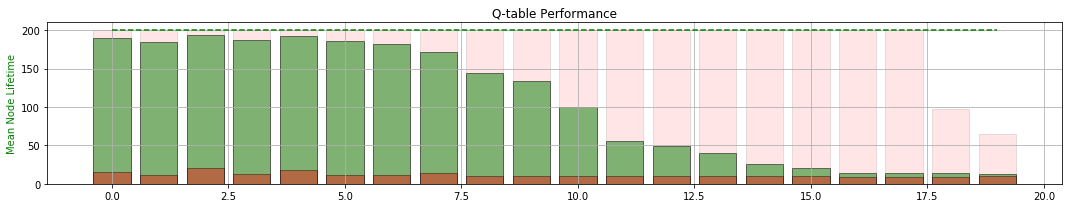

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  72312
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  11.325
Validating... MEAN TIME:  11.595
Validating... MEAN TIME:  10.85
Validating... MEAN TIME:  10.895
Validating... MEAN TIME:  10.55
TRAINING TIME:0:00:11.942997


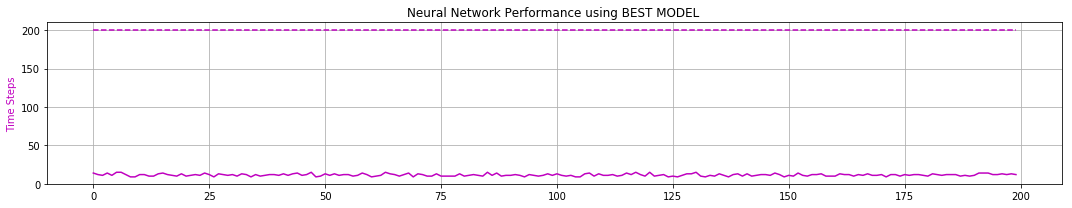

0 -max- [ 0.204  0.995  0.209  1.674  0.325]
0 -min- [-1.552 -1.878 -0.209 -1.385  0.226]

1 -max- [ 0.199  1.131  0.209  1.655  0.350]
1 -min- [-1.568 -1.754 -0.209 -1.610  0.250]

2 -max- [ 0.205  0.973  0.206  1.669  0.374]
2 -min- [-1.422 -1.849 -0.209 -1.591  0.275]

3 -max- [ 0.216  1.191  0.209  1.673  0.400]
3 -min- [-1.554 -1.853 -0.209 -1.687  0.301]

4 -max- [ 0.229  1.130  0.209  1.713  0.425]
4 -min- [-1.497 -1.854 -0.209 -1.621  0.326]

5 -max- [ 0.195  1.013  0.209  2.208  0.449]
5 -min- [-1.538 -2.315 -0.209 -1.528  0.351]

6 -max- [ 0.214  1.133  0.209  1.870  0.475]
6 -min- [-1.585 -1.943 -0.208 -1.580  0.375]

7 -max- [ 0.204  1.002  0.205  1.718  0.499]
7 -min- [-1.668 -1.849 -0.209 -1.578  0.400]

8 -max- [ 0.211  1.020  0.207  1.968  0.525]
8 -min- [-1.789 -2.106 -0.209 -1.595  0.426]

9 -max- [ 0.214  1.009  0.209  1.629  0.549]
9 -min- [-1.692 -1.865 -0.209 -1.538  0.451]

10 -max- [ 0.205  1.014  0.208  1.621  0.574]
10 -min- [-1.799 -1.758 -0.209 -1.593  0.475

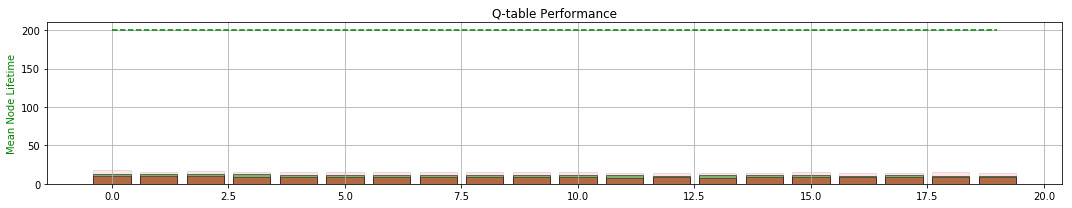

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  76312
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  10.655
Validating... MEAN TIME:  10.14
Validating... MEAN TIME:  11.875
Validating... MEAN TIME:  16.69
Validating... MEAN TIME:  17.345
TRAINING TIME:0:00:12.385283


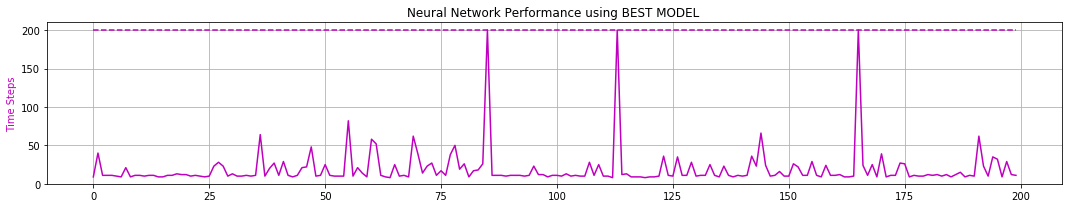

0 -max- [ 0.214  1.020  0.050  0.054  0.325]
0 -min- [-0.049 -0.050 -0.209 -1.667  0.226]

1 -max- [ 0.214  1.021  0.050  0.257  0.350]
1 -min- [-0.050 -0.240 -0.209 -1.682  0.250]

2 -max- [ 0.208  1.023  0.053  0.348  0.375]
2 -min- [-0.053 -0.214 -0.209 -1.693  0.275]

3 -max- [ 0.224  1.190  0.050  0.052  0.400]
3 -min- [-0.050 -0.050 -0.209 -1.675  0.300]

4 -max- [ 0.210  1.193  0.049  0.063  0.424]
4 -min- [-0.050 -0.050 -0.209 -1.869  0.326]

5 -max- [ 0.207  1.384  0.049  0.050  0.449]
5 -min- [-0.049 -0.049 -0.209 -2.045  0.350]

6 -max- [ 0.216  1.219  0.050  0.313  0.474]
6 -min- [-0.050 -0.169 -0.209 -1.859  0.375]

7 -max- [ 0.208  1.217  0.050  0.259  0.500]
7 -min- [-0.050 -0.163 -0.209 -1.987  0.400]

8 -max- [ 0.218  1.216  0.049  0.326  0.524]
8 -min- [-0.050 -0.177 -0.209 -1.854  0.425]

9 -max- [ 0.214  1.189  0.049  0.272  0.549]
9 -min- [-0.050 -0.229 -0.209 -1.878  0.450]

10 -max- [ 0.209  1.211  0.050  0.308  0.575]
10 -min- [-0.049 -0.188 -0.209 -2.015  0.475

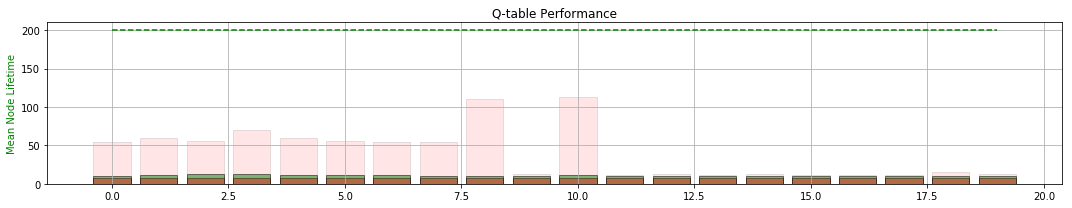

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  80312
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.49
Validating... MEAN TIME:  9.52
Validating... MEAN TIME:  9.36
Validating... MEAN TIME:  9.3
Validating... MEAN TIME:  9.775
TRAINING TIME:0:00:12.002324


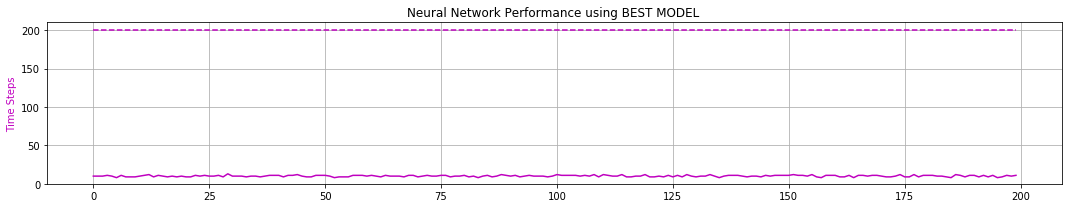

0 -max- [ 0.212  1.580  0.055  0.676  0.324]
0 -min- [-0.316 -0.794 -0.209 -2.322  0.225]

1 -max- [ 0.213  1.521  0.086  0.691  0.349]
1 -min- [-0.363 -0.805 -0.209 -2.349  0.250]

2 -max- [ 0.205  1.405  0.092  0.718  0.375]
2 -min- [-0.308 -0.805 -0.209 -2.252  0.275]

3 -max- [ 0.221  1.598  0.186  2.843  0.397]
3 -min- [-0.419 -2.355 -0.209 -2.348  0.301]

4 -max- [ 0.216  1.588  0.065  0.690  0.425]
4 -min- [-0.351 -0.807 -0.209 -2.324  0.326]

5 -max- [ 0.202  1.604  0.093  0.703  0.449]
5 -min- [-0.317 -0.806 -0.209 -2.330  0.351]

6 -max- [ 0.218  1.605  0.069  0.717  0.474]
6 -min- [-0.305 -0.801 -0.209 -2.369  0.377]

7 -max- [ 0.206  1.765  0.060  0.692  0.500]
7 -min- [-0.293 -0.805 -0.209 -2.658  0.400]

8 -max- [ 0.206  1.606  0.062  0.676  0.525]
8 -min- [-0.752 -0.803 -0.209 -2.394  0.426]

9 -max- [ 0.218  1.749  0.049  0.298  0.550]
9 -min- [-0.051 -0.224 -0.209 -2.641  0.451]

10 -max- [ 0.216  1.603  0.058  0.689  0.575]
10 -min- [-0.803 -0.806 -0.209 -2.337  0.475

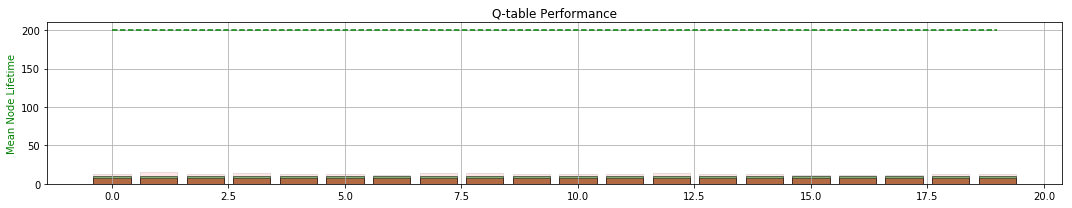

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  84312
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.355
Validating... MEAN TIME:  9.38
Validating... MEAN TIME:  11.57
Validating... MEAN TIME:  10.065
Validating... MEAN TIME:  9.33
TRAINING TIME:0:00:12.045597


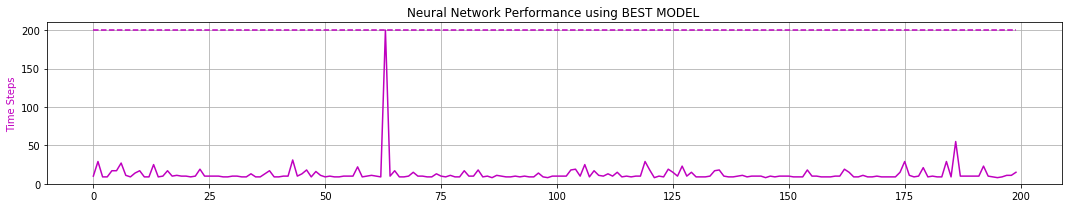

0 -max- [ 0.213  1.415  0.050  0.328  0.324]
0 -min- [-0.049 -0.214 -0.209 -2.122  0.225]

1 -max- [ 0.221  1.411  0.050  0.338  0.349]
1 -min- [-0.050 -0.216 -0.209 -2.152  0.251]

2 -max- [ 0.209  1.410  0.050  0.340  0.374]
2 -min- [-0.050 -0.245 -0.209 -2.194  0.275]

3 -max- [ 0.213  1.412  0.050  0.314  0.399]
3 -min- [-0.050 -0.175 -0.209 -2.164  0.300]

4 -max- [ 0.217  1.595  0.049  0.328  0.424]
4 -min- [-0.050 -0.225 -0.209 -2.331  0.325]

5 -max- [ 0.215  1.603  0.049  0.329  0.449]
5 -min- [-0.049 -0.224 -0.209 -2.334  0.350]

6 -max- [ 0.213  1.605  0.050  0.050  0.475]
6 -min- [-0.050 -0.049 -0.209 -2.397  0.376]

7 -max- [ 0.202  1.767  0.053  0.329  0.500]
7 -min- [-0.050 -0.242 -0.209 -2.661  0.400]

8 -max- [ 0.219  1.712  0.051  0.275  0.523]
8 -min- [-0.050 -0.168 -0.209 -2.630  0.425]

9 -max- [ 0.218  1.749  0.049  0.298  0.549]
9 -min- [-0.051 -0.224 -0.209 -2.652  0.450]

10 -max- [ 0.208  1.602  0.050  0.049  0.574]
10 -min- [-0.049 -0.050 -0.209 -2.401  0.475

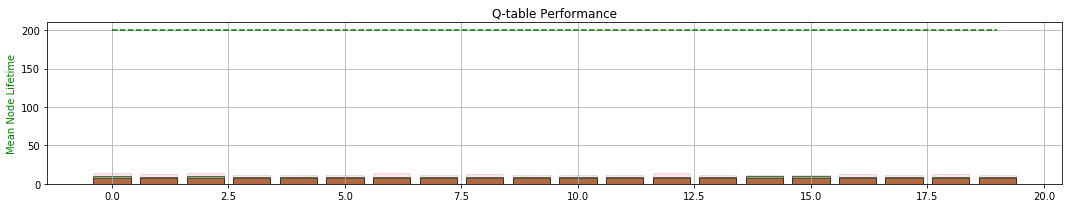

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  88312
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.38
Validating... MEAN TIME:  9.365
Validating... MEAN TIME:  9.4
Validating... MEAN TIME:  9.685
Validating... MEAN TIME:  9.4
TRAINING TIME:0:00:12.015932


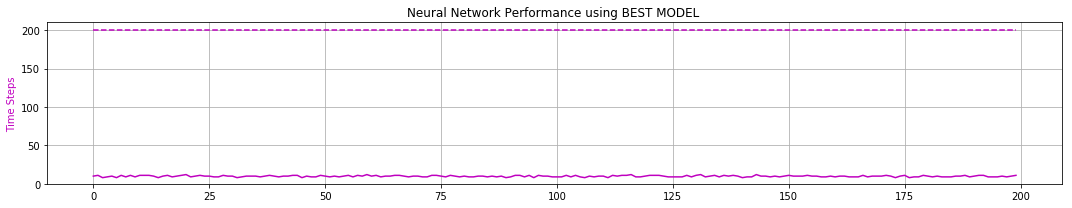

0 -max- [ 0.213  1.992  0.050  0.233  0.325]
0 -min- [-0.049 -0.196 -0.209 -2.961  0.225]

1 -max- [ 0.208  1.996  0.050  0.306  0.350]
1 -min- [-0.050 -0.165 -0.209 -2.949  0.250]

2 -max- [ 0.227  1.952  0.050  0.325  0.374]
2 -min- [-0.050 -0.221 -0.209 -2.937  0.275]

3 -max- [ 0.228  1.990  0.050  0.050  0.399]
3 -min- [-0.050 -0.050 -0.209 -2.951  0.300]

4 -max- [ 0.210  1.980  0.049  0.309  0.425]
4 -min- [-0.050 -0.175 -0.209 -2.966  0.326]

5 -max- [ 0.193  1.988  0.049  0.311  0.450]
5 -min- [-0.049 -0.151 -0.209 -2.951  0.350]

6 -max- [ 0.217  1.997  0.050  0.318  0.474]
6 -min- [-0.050 -0.238 -0.209 -2.973  0.375]

7 -max- [ 0.195  1.944  0.050  0.320  0.499]
7 -min- [-0.050 -0.151 -0.209 -2.912  0.401]

8 -max- [ 0.214  1.998  0.049  0.255  0.525]
8 -min- [-0.050 -0.150 -0.209 -2.973  0.426]

9 -max- [ 0.213  1.965  0.049  0.251  0.550]
9 -min- [-0.050 -0.170 -0.209 -2.979  0.451]

10 -max- [ 0.205  1.969  0.050  0.281  0.574]
10 -min- [-0.049 -0.226 -0.209 -2.968  0.475

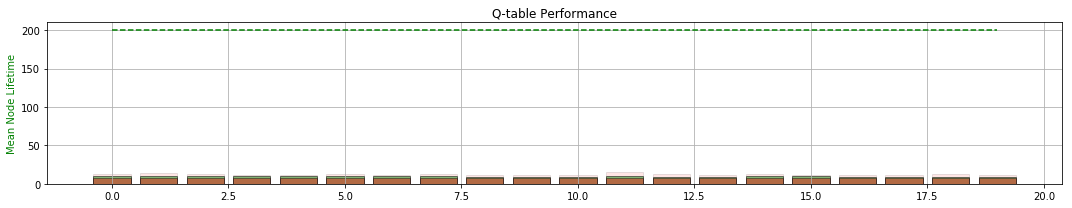

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  92312
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.71
Validating... MEAN TIME:  11.96
Validating... MEAN TIME:  9.29
Validating... MEAN TIME:  9.335
Validating... MEAN TIME:  9.37
TRAINING TIME:0:00:12.099240


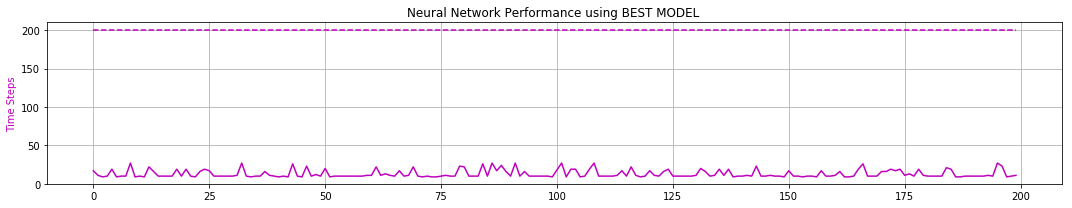

0 -max- [ 0.212  1.753  0.050  0.049  0.325]
0 -min- [-0.049 -0.050 -0.209 -2.590  0.226]

1 -max- [ 0.220  1.800  0.050  0.308  0.350]
1 -min- [-0.050 -0.219 -0.209 -2.649  0.250]

2 -max- [ 0.220  1.795  0.050  0.296  0.372]
2 -min- [-0.050 -0.166 -0.209 -2.655  0.276]

3 -max- [ 0.228  1.799  0.050  0.330  0.400]
3 -min- [-0.051 -0.168 -0.209 -2.657  0.300]

4 -max- [ 0.212  1.790  0.049  0.334  0.425]
4 -min- [-0.050 -0.193 -0.209 -2.644  0.326]

5 -max- [ 0.215  1.800  0.049  0.310  0.450]
5 -min- [-0.049 -0.177 -0.209 -2.651  0.350]

6 -max- [ 0.217  1.801  0.050  0.332  0.474]
6 -min- [-0.050 -0.237 -0.209 -2.654  0.375]

7 -max- [ 0.215  1.805  0.050  0.347  0.500]
7 -min- [-0.050 -0.201 -0.209 -2.651  0.401]

8 -max- [ 0.214  1.802  0.049  0.248  0.525]
8 -min- [-0.050 -0.168 -0.209 -2.655  0.427]

9 -max- [ 0.218  1.792  0.049  0.346  0.549]
9 -min- [-0.050 -0.160 -0.209 -2.705  0.450]

10 -max- [ 0.224  1.798  0.050  0.311  0.574]
10 -min- [-0.049 -0.168 -0.209 -2.652  0.475

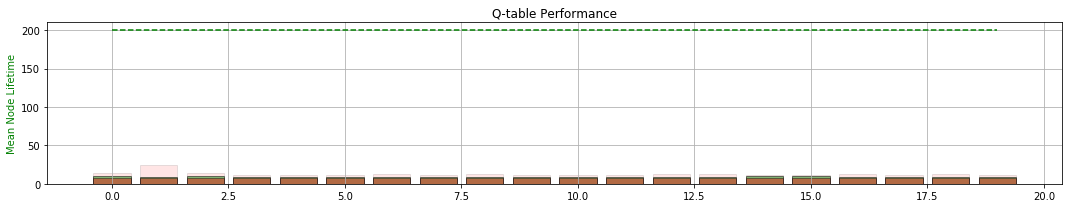

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  96312
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.335
Validating... MEAN TIME:  9.325
Validating... MEAN TIME:  9.32
Validating... MEAN TIME:  9.26
Validating... MEAN TIME:  9.4
TRAINING TIME:0:00:11.450521


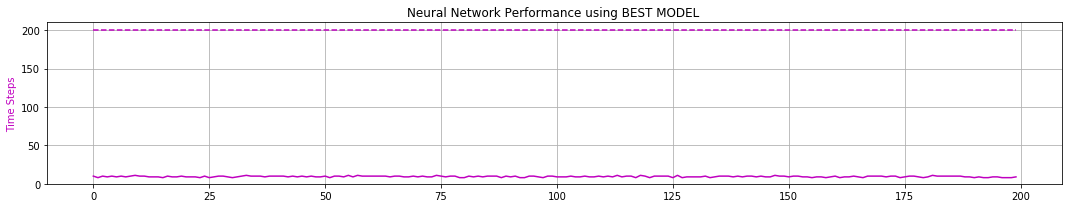

0 -max- [ 0.213  1.992  0.050  0.345  0.325]
0 -min- [-0.049 -0.237 -0.209 -2.974  0.225]

1 -max- [ 0.208  1.996  0.201  2.924  0.350]
1 -min- [-0.275 -2.161 -0.209 -2.949  0.250]

2 -max- [ 0.227  1.952  0.050  0.611  0.374]
2 -min- [-0.050 -0.382 -0.209 -2.937  0.275]

3 -max- [ 0.228  1.990  0.050  0.050  0.399]
3 -min- [-0.050 -0.050 -0.209 -2.983  0.300]

4 -max- [ 0.210  1.980  0.049  0.309  0.425]
4 -min- [-0.050 -0.175 -0.209 -2.966  0.326]

5 -max- [ 0.193  1.988  0.049  0.311  0.450]
5 -min- [-0.049 -0.151 -0.209 -2.951  0.350]

6 -max- [ 0.217  1.997  0.050  0.560  0.474]
6 -min- [-0.050 -0.427 -0.209 -2.973  0.375]

7 -max- [ 0.195  1.944  0.050  0.320  0.499]
7 -min- [-0.050 -0.151 -0.209 -2.912  0.401]

8 -max- [ 0.214  1.998  0.049  0.255  0.525]
8 -min- [-0.050 -0.150 -0.209 -2.973  0.426]

9 -max- [ 0.213  1.965  0.049  0.251  0.550]
9 -min- [-0.050 -0.170 -0.209 -2.979  0.451]

10 -max- [ 0.205  1.969  0.050  0.281  0.574]
10 -min- [-0.049 -0.226 -0.209 -2.968  0.475

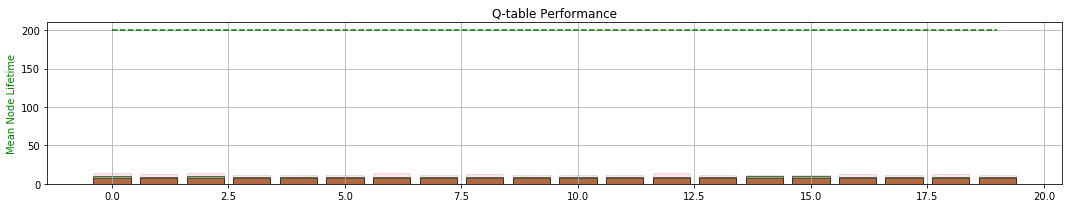

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  100000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.345
Validating... MEAN TIME:  9.365
Validating... MEAN TIME:  9.415
Validating... MEAN TIME:  9.39
Validating... MEAN TIME:  9.375
TRAINING TIME:0:00:12.074459


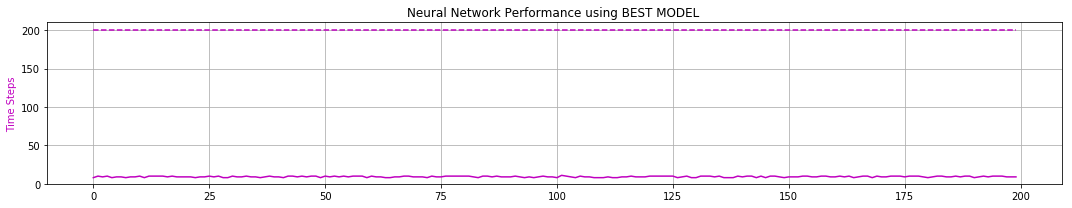

0 -max- [ 0.213  1.992  0.050  0.345  0.325]
0 -min- [-0.049 -0.237 -0.209 -2.974  0.225]

1 -max- [ 0.208  1.996  0.050  0.317  0.350]
1 -min- [-0.050 -0.232 -0.209 -2.949  0.250]

2 -max- [ 0.227  1.952  0.050  0.325  0.374]
2 -min- [-0.050 -0.221 -0.209 -2.937  0.275]

3 -max- [ 0.228  1.990  0.050  0.050  0.399]
3 -min- [-0.050 -0.050 -0.209 -2.983  0.300]

4 -max- [ 0.210  1.980  0.049  0.309  0.425]
4 -min- [-0.050 -0.175 -0.209 -2.966  0.326]

5 -max- [ 0.193  1.988  0.049  0.311  0.450]
5 -min- [-0.049 -0.151 -0.209 -2.951  0.350]

6 -max- [ 0.217  1.997  0.050  0.318  0.474]
6 -min- [-0.050 -0.238 -0.209 -2.973  0.375]

7 -max- [ 0.195  1.944  0.050  0.320  0.499]
7 -min- [-0.050 -0.151 -0.209 -2.912  0.401]

8 -max- [ 0.214  1.998  0.049  0.255  0.525]
8 -min- [-0.050 -0.150 -0.209 -2.973  0.426]

9 -max- [ 0.213  1.965  0.049  0.251  0.550]
9 -min- [-0.050 -0.170 -0.209 -2.979  0.451]

10 -max- [ 0.205  1.969  0.050  0.281  0.574]
10 -min- [-0.049 -0.226 -0.209 -2.968  0.475

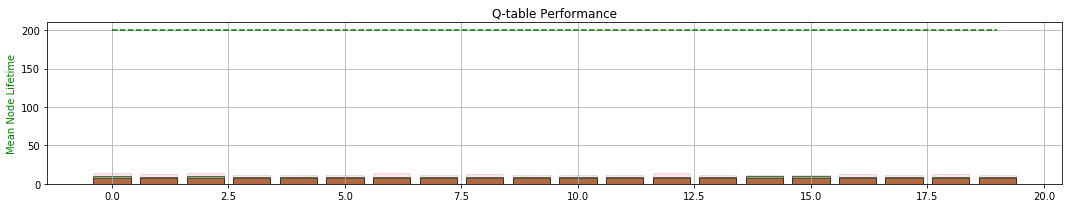

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  100000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.32
Validating... MEAN TIME:  9.315
Validating... MEAN TIME:  9.38
Validating... MEAN TIME:  9.355
Validating... MEAN TIME:  9.335
TRAINING TIME:0:00:11.945623


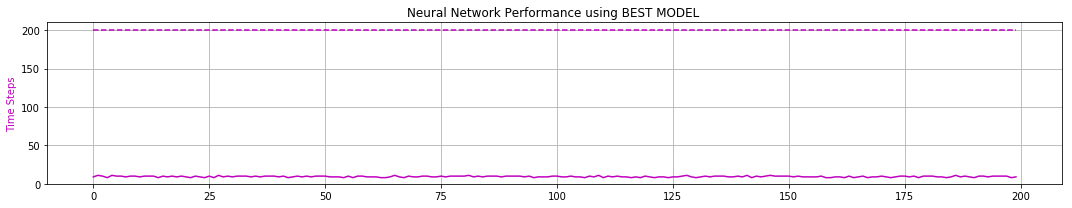

0 -max- [ 0.213  1.992  0.050  0.345  0.325]
0 -min- [-0.049 -0.237 -0.209 -2.974  0.225]

1 -max- [ 0.208  1.996  0.050  0.317  0.350]
1 -min- [-0.050 -0.232 -0.209 -2.949  0.250]

2 -max- [ 0.227  1.952  0.050  0.325  0.374]
2 -min- [-0.050 -0.221 -0.209 -2.937  0.275]

3 -max- [ 0.228  1.990  0.050  0.050  0.399]
3 -min- [-0.050 -0.050 -0.209 -2.983  0.300]

4 -max- [ 0.210  1.980  0.049  0.309  0.425]
4 -min- [-0.050 -0.175 -0.209 -2.966  0.326]

5 -max- [ 0.193  1.988  0.049  0.311  0.450]
5 -min- [-0.049 -0.151 -0.209 -2.951  0.350]

6 -max- [ 0.217  1.997  0.050  0.318  0.474]
6 -min- [-0.050 -0.238 -0.209 -2.973  0.375]

7 -max- [ 0.195  1.944  0.050  0.320  0.499]
7 -min- [-0.050 -0.151 -0.209 -2.912  0.401]

8 -max- [ 0.214  1.998  0.049  0.255  0.525]
8 -min- [-0.050 -0.150 -0.209 -2.973  0.426]

9 -max- [ 0.213  1.965  0.049  0.251  0.550]
9 -min- [-0.050 -0.170 -0.209 -2.979  0.451]

10 -max- [ 0.205  1.969  0.050  0.281  0.574]
10 -min- [-0.049 -0.226 -0.209 -2.968  0.475

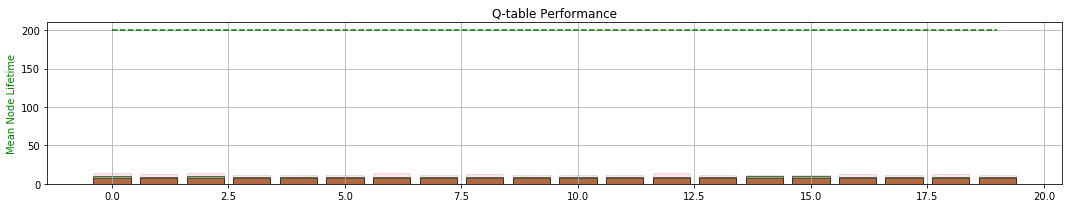

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  100000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.4
Validating... MEAN TIME:  9.32
Validating... MEAN TIME:  9.39
Validating... MEAN TIME:  9.29
Validating... MEAN TIME:  9.255
TRAINING TIME:0:00:11.950449


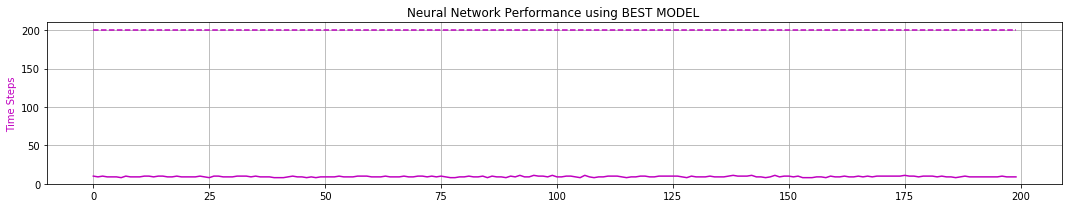

0 -max- [ 0.213  1.992  0.050  0.345  0.325]
0 -min- [-0.049 -0.237 -0.209 -2.974  0.225]

1 -max- [ 0.208  1.996  0.050  0.317  0.350]
1 -min- [-0.050 -0.232 -0.209 -2.949  0.250]

2 -max- [ 0.227  1.952  0.050  0.325  0.374]
2 -min- [-0.050 -0.221 -0.209 -2.937  0.275]

3 -max- [ 0.228  1.990  0.050  0.050  0.399]
3 -min- [-0.050 -0.050 -0.209 -2.983  0.300]

4 -max- [ 0.210  1.980  0.049  0.309  0.425]
4 -min- [-0.050 -0.175 -0.209 -2.966  0.326]

5 -max- [ 0.193  1.988  0.049  0.311  0.450]
5 -min- [-0.049 -0.151 -0.209 -2.951  0.350]

6 -max- [ 0.217  1.997  0.050  0.318  0.474]
6 -min- [-0.050 -0.238 -0.209 -2.973  0.375]

7 -max- [ 0.195  1.944  0.050  0.320  0.499]
7 -min- [-0.050 -0.151 -0.209 -2.912  0.401]

8 -max- [ 0.214  1.998  0.049  0.255  0.525]
8 -min- [-0.050 -0.150 -0.209 -2.973  0.426]

9 -max- [ 0.213  1.965  0.049  0.251  0.550]
9 -min- [-0.050 -0.170 -0.209 -2.979  0.451]

10 -max- [ 0.205  1.969  0.050  0.281  0.574]
10 -min- [-0.049 -0.226 -0.209 -2.968  0.475

In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    print("\n")
    print("ITERATION #", iteration)
    print("TABULAR EPSILON = ", T_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("LARGEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.max().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = 0.5 + np.random.uniform(-0.3,0.3)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = 0.5 + np.random.uniform(-0.3,0.3)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    for node_id in range(NO_OF_NODES):
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
        # CREATE STATE COMBINATIONS
        ###############################################

        
        ###############################################
    node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                        [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                        [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

    # SAVE QFILE
    node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
    np.save(node_QFILE, node_q_table)
        #############################################################################################################################################
    stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()
    

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  4071.0
Total Serial Timesteps   :  9632663.0
Speed-up                 :  2366.17


In [21]:
pool.close()
pool.join()